# **0: Connecting to Google Drive and Github**

In [222]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [223]:
%cd /content/drive/MyDrive/Github/

/content/drive/MyDrive/Github


##### Github

In [224]:
# !git init real_estate_uni_bivariable

In [225]:
# %cd real_estate_uni_bivariable

In [226]:
# %ls -a

In [227]:
# !git status

In [228]:
# !git add .

In [229]:
# !git commit -m "new commit"

# **Dataset 1: Página web de anuncios inmobiliarios -> ASKING PRICE**

## **Consideraciones iniciales o punto de partida**

**VARIABLE DEPENDIENTE:** el precio de venta (asking-price). La variable se llama "PRICE".

Este análisis se realiza para conocer el precio de venta de apartamentos (también conocido como Asking Price) que los vendedores están publicando en los anuncios de una página web de anuncios inmobiliarios. El objetivo es poder predecir el precio de venta de un inmueble concreto en función de sus características.
*   Se ha extraído una muestra de la población de datos que se quiere analizar. La muestra coincide con las características del inmueble que se quiere predecir. Se ha de tener en cuenta que el mercado inmobiliario de esta región es muy particular y existen grandes variaciones en el precio entre localidades cercanas.
*   En cuanto al tipo de inmueble, no se han analizado casas individuales ni adosados, sólo apartamentos (ya sean estudios, apartamentos de una habitación, de dos habitaciones, duplex o triplex. También apartamentos de nueva construcción).
*   Respecto al precio, se ha establecido un rango entre 0 y 300.000, ya que es el rango de precios que nos interesa, además, debido a problemas con el web scraping, no hemos podido ampliar esta lista para incluir otro tipo de inmuebles o aquellos con un precio superior. Es por ello que no ha sido necesario hacer un estudio de los outliers.
*   El dataset es muy pequeño (unas 180 líneas) ya que la zona geográfica está muy restringida. Se han recopilado datos durante 2 meses, desde el 29 de junio hasta el 29 de agosto, y se han añadido 3 nuevas columnas al final del dataset para gestionar los movimientos ocurridos a lo largo del tiempo: sold (y/n), selling_time (se ha calculado manualmente el tiempo transcurrido entre la aparición del anuncio y su desaparición) y old_price (se han registrado los cambios en el precio de venta, al alza o a la baja).
*   Al tener tan pocas filas, corro el riesgo real (y así se confirma desde las primeras pruebas) de incurrir en overfitting. Es por ello que voy a simplificar el algunas columnas, aquellas que salen de la variable general "tags", para intentar llegar a la parte de ejecución de los modelos con menos columnas. En concreto hago que las variables "chambres" (habitaciones) y "étages" (niveles) pasen de ser variables categóricas a variables numéricas.

## **1. Importar archivo**
---

In [230]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Github/real_estate_uni_bivariable/curated_list.csv", encoding='utf-8')
df.head(2)

,id,object,task_id,annonce_id,agency_id,agency_page,agency_contact_name,agency_img_url,agency_phone_number,agency_has_email,...,short_description,transaction_type,tags,url,virtual_visit_url,collected_at,input_url,sold,selling_time,old_price
0,5830291,result,52,220393829,308701,https://www.siteweb.com/professionnels/agents-...,agence-33779,https://v.siteweb.com/s/width/150/logos/1/p/r/...,10 10 10 10 10,t,...,xxxxxxxxx,2,"2 pieces, 1 chambre, 20 m2, etage 3/0, ascenseur",https://www.siteweb.com/annonces/achat/2/ville...,NaN,2024-06-29 14:07:02.221603,"https://www.siteweb.com/list.htm?projects=2,5&...",n,NaN,110000.0
1,5928271,result,49195394,224562683,531006,https://www.siteweb.com/professionnels/agences...,agence-131251,NaN,10 10 10 10 10,t,...,xxxxxxxxx,2,"1 piece, 23 m2, etage 3/–",https://www.siteweb.com/annonces/achat/2/ville...,NaN,2024-07-23 10:22:47.828507,"https://www.siteweb.com/list.htm?projects=2,5&...",n,NaN,NaN


In [231]:
df_a_predecir = pd.read_csv("/content/drive/MyDrive/Github/real_estate_uni_bivariable/prediccion.csv", encoding='utf-8')
df_a_predecir.head(2)

,id,object,task_id,annonce_id,agency_id,agency_page,agency_contact_name,agency_img_url,agency_phone_number,agency_has_email,...,short_description,transaction_type,tags,url,virtual_visit_url,collected_at,input_url,sold,selling_time,old_price
0,6000000,result,42424242,424242424,424242,https://www.siteweb.com/professionnels/agences...,agence-424242,NaN,42 42 42 42 42,t,...,NaN,2,"2 pieces, 1 chambre, 42m2, etage 1/2, terras...",NaN,,NaN,,n,,NaN


## **2. Limpieza y normalización de datos**
---

## a) Supresión de identificadores y demás variables no relevantes (por ejemplo aquellas cuya información está repetida o que tienen muchos valores en blanco o nulos).

In [232]:
df.columns.tolist()

['id',
 'object',
 'task_id',
 'annonce_id',
 'agency_id',
 'agency_page',
 'agency_contact_name',
 'agency_img_url',
 'agency_phone_number',
 'agency_has_email',
 'agency_link',
 'address',
 'area',
 'bedrooms_count',
 'business_unit',
 'coownership_annual_charges',
 'coownership_number_of_lots',
 'coownership_is_syndic_procedure',
 'contact_is_private_seller',
 'contact_email',
 'description',
 'district',
 'dpe',
 'estate_type',
 'electricity_consumption',
 'estate_type_id',
 'ges',
 'gas_emissions',
 'highlighting_level',
 'insee_code',
 'is_furnished',
 'is_exclusive',
 'is_expired',
 'monthly_price',
 'nature',
 'postal_code',
 'picture_count',
 'price',
 'price_per_meter',
 'price_decrease_percent',
 'publication_id',
 'rooms',
 'short_description',
 'transaction_type',
 'tags',
 'url',
 'virtual_visit_url',
 'collected_at',
 'input_url',
 'sold',
 'selling_time',
 'old_price']

In [233]:
df.drop_duplicates(inplace=True)

In [234]:
df.drop(columns=['id','object','task_id','annonce_id','agency_id','agency_page','agency_contact_name','agency_img_url','agency_phone_number','agency_has_email',
                 'agency_link','address','bedrooms_count','business_unit','coownership_annual_charges','coownership_number_of_lots','coownership_is_syndic_procedure',
                 'contact_email','description','electricity_consumption','estate_type_id','gas_emissions','highlighting_level','insee_code','is_expired','monthly_price',
                 'nature','postal_code','picture_count',"price_decrease_percent", 'price_per_meter','publication_id', 'short_description', 'transaction_type', 'url','virtual_visit_url','collected_at','input_url'], axis=1, inplace=True)

df_a_predecir.drop(columns=['id','object','task_id','annonce_id','agency_id','agency_page','agency_contact_name','agency_img_url','agency_phone_number','agency_has_email',
                 'agency_link','address','bedrooms_count','business_unit','coownership_annual_charges','coownership_number_of_lots','coownership_is_syndic_procedure',
                 'contact_email','description','electricity_consumption','estate_type_id','gas_emissions','highlighting_level','insee_code','is_expired','monthly_price',
                 'nature','postal_code','picture_count',"price_decrease_percent", 'price_per_meter','publication_id', 'short_description', 'transaction_type', 'url','virtual_visit_url','collected_at','input_url'], axis=1, inplace=True)

df.head(2)
df_a_predecir.head()

,area,contact_is_private_seller,district,dpe,estate_type,features,ges,is_furnished,is_exclusive,rooms,tags,sold,selling_time,old_price
0,42.3,t,3,C,2,NaN,A,f,t,2,"2 pieces, 1 chambre, 42m2, etage 1/2, terras...",n,,NaN


## b) Tratamiento de los valores nulos de las columnas que se quedan: en este caso dejamos los nulos ya que:
- En el caso de los nulos en DPE y GES constituyen menos del 5% del total de los datos de esa variable.
- En el caso de price_decrease_percent, selling_time y old_price, es normal que haya tantos valores nulos o en blanco ya que son columnas en las que los nulos tienen su propio significado y se pueden y deben analizar de esta manera).

In [235]:
df.columns.tolist()

['area',
 'contact_is_private_seller',
 'district',
 'dpe',
 'estate_type',
 'ges',
 'is_furnished',
 'is_exclusive',
 'price',
 'rooms',
 'tags',
 'sold',
 'selling_time',
 'old_price']

In [236]:
df.isnull().sum()

,0
area,0
contact_is_private_seller,0
district,0
dpe,6
estate_type,0
ges,6
is_furnished,0
is_exclusive,0
price,0
rooms,4


In [237]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_palette("pastel")

### Variable: AREA

In [238]:
df.area.isnull().sum()
df.dropna(subset=['area'], inplace=True)

In [239]:
df.area = df.area.astype(int)
df_a_predecir.area = df_a_predecir.area.astype(int)

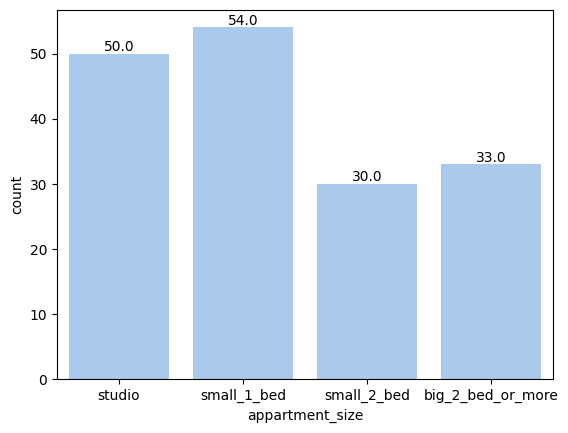

In [240]:
df["appartment_size"] = pd.cut(df.area, bins=[0,35,49,66,df.area.max()], labels=["studio", "small_1_bed", "small_2_bed", "big_2_bed_or_more"])
df_a_predecir["appartment_size"] = pd.cut(df_a_predecir.area, bins=[0,35,49,66,df.area.max()], labels=["studio", "small_1_bed", "small_2_bed", "big_2_bed_or_more"])

ax = sns.countplot(df, x="appartment_size")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: CONTACT IS PRIVATE SELLER OR A REAL ESTATE AGENT

In [241]:
df.contact_is_private_seller.replace(["t", "f"], [1,0], inplace=True)
df_a_predecir.contact_is_private_seller.replace(["t", "f"], [1,0], inplace=True)

In [242]:
df.contact_is_private_seller.value_counts()

,count
contact_is_private_seller,
0,161
1,6


### Variable: DISTRICT

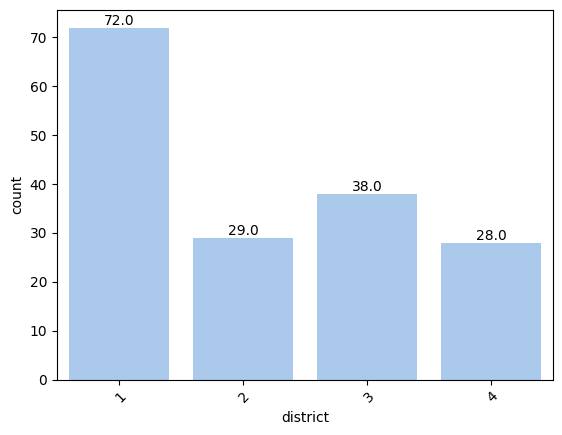

In [243]:
ax = sns.countplot(df, x="district")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Variable: DPE (Diagnóstico Energético)

Muy importante debido a la regulación europea que impedirá vender o alquilar inmuebles E, F y G en un futuro más o menos lejano

In [244]:
df.dpe.fillna('C',inplace=True)
# df_a_predecir.dpe.fillna('C',inplace=True)

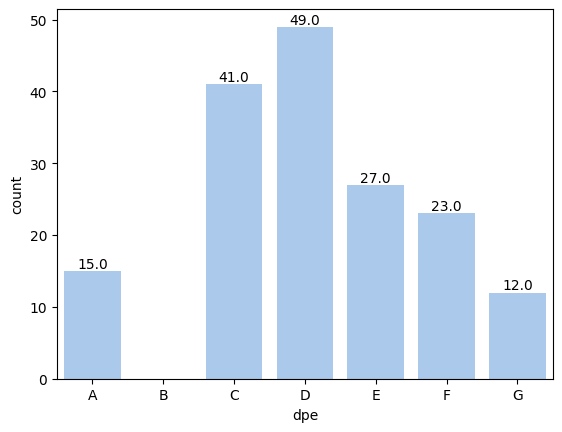

In [245]:
category_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

ax = sns.countplot(df, x="dpe", order=category_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: ESTATE TYPE

(Appartement Neuf significa Apartamento de Nueva Construcción - Obra nueva)

In [246]:
df.estate_type.replace('appartement', 'Appartement',inplace=True)
df.estate_type.replace('studio', 'Studio',inplace=True)

# df_a_predecir.estate_type.replace('appartement', 'Appartement',inplace=True)
# df_a_predecir.estate_type.replace('studio', 'Studio',inplace=True)

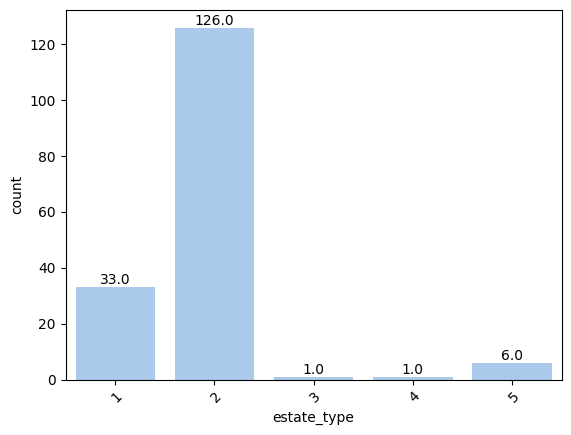

In [247]:
ax = sns.countplot(df, x="estate_type")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.show()

### Variable: GES (Emisiones de Gas de Efecto Invernadero)

Los apartamentos con calderas de gas son los que más gases emiten pero no son muy numerosos en Francia, desde luego menos que en España.

In [248]:
df.ges.fillna('A',inplace=True)
# df_a_predecir.ges.fillna('A',inplace=True)

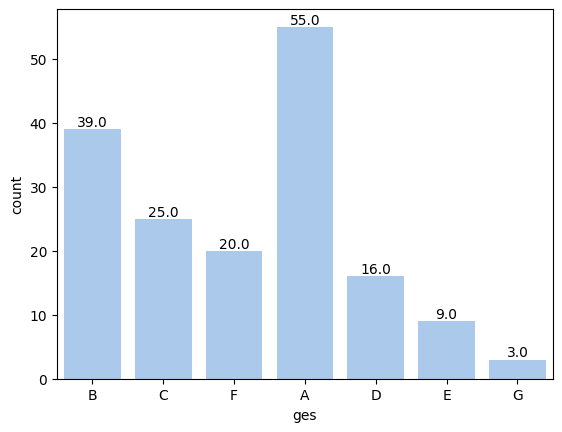

In [249]:
ax = sns.countplot(df, x="ges")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: IS FURNISHED

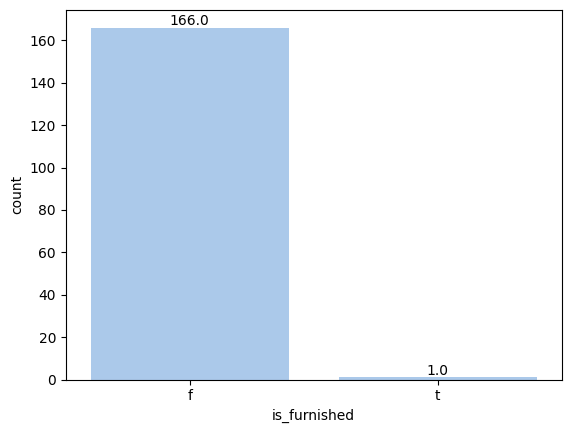

In [250]:
ax = sns.countplot(df, x="is_furnished")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: IS EXCLUSIVE

Se refiere a si el vendedor a mandatado varias agencias o sólo a una en exclusiva. Los mandatos exclusivos suelen significar rebajas en los honorarios para los vendedores.

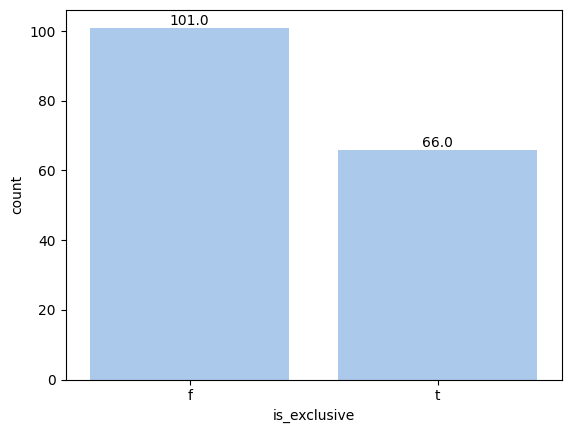

In [251]:
ax = sns.countplot(df, x="is_exclusive")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: PRICE --> <font color="red">ES NUESTRA VARIABLE DEPENDIENTE.</font>

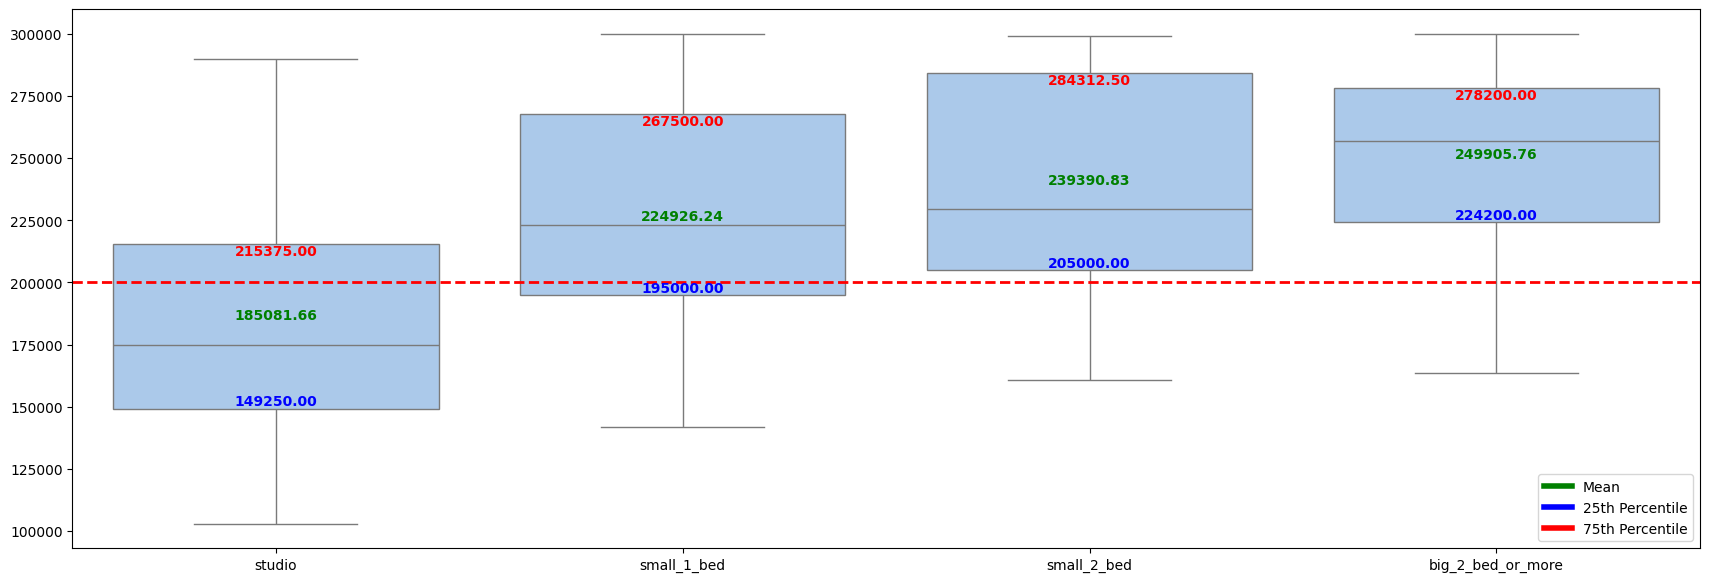

In [252]:
fig, ax = plt.subplots(figsize=(21, 7))

# Create the boxplot
boxplot = sns.boxplot(x=df['appartment_size'].values, y=df['price'].values, ax=ax)

# Calculate the statistics: mean, 25th percentile, and 75th percentile
grouped = df.groupby('appartment_size', observed=False)['price']
means = grouped.mean()
q1 = grouped.quantile(0.25)
q3 = grouped.quantile(0.75)

# Add a horizontal line at the value of 200000
ax.axhline(y=200000, color='red', linestyle='--', linewidth=2, label='Threshold = 200000')

# Annotate these statistics on the plot
for i, appartment_size in enumerate(means.index):
    ax.text(i, means[appartment_size], f'{means[appartment_size]:.2f}',
            horizontalalignment='center', verticalalignment='baseline', color='green', weight='bold')
    ax.text(i, q1[appartment_size], f'{q1[appartment_size]:.2f}',
            horizontalalignment='center', verticalalignment='bottom', color='blue', weight='bold')
    ax.text(i, q3[appartment_size], f'{q3[appartment_size]:.2f}',
            horizontalalignment='center', verticalalignment='top', color='red', weight='bold')

# Add a legend explaining the text annotations
handles = [plt.Line2D([0], [0], color='green', lw=4),
           plt.Line2D([0], [0], color='blue', lw=4),
           plt.Line2D([0], [0], color='red', lw=4)]
labels = ['Mean', '25th Percentile', '75th Percentile']
ax.legend(handles, labels)

plt.show()


Tenemos una primera aproximación de los precios que se practican en este portal inmobiliario. El tipo de inmueble que nos interesa es el small_1_bed, por lo tanto, vemos que el precio definido por los algoritmos de IA debería estar en el rango entre los 189000 y los 252000, con una fuerte probabilidad de que se encuentre cercano a los 218000 euros.

Vamos ahora a analizar los precios por tamaño y por distrito.

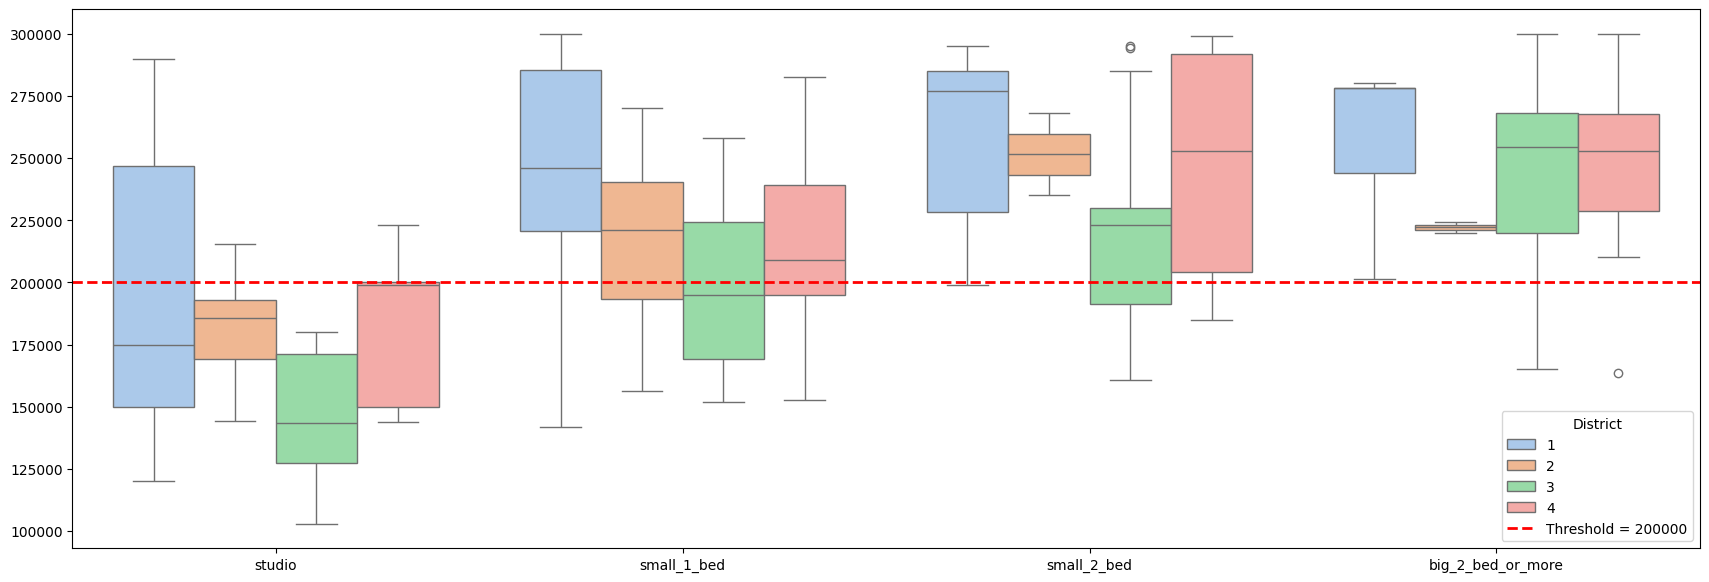

In [253]:
fig, ax = plt.subplots(figsize=(21, 7))

# Create the boxplot
boxplot = sns.boxplot(x=df['appartment_size'].values, y=df['price'].values, hue=df['district'], ax=ax, palette="pastel")

# Calculate the statistics: mean, 25th percentile, and 75th percentile
grouped = df.groupby(['appartment_size', 'district'], observed=False)['price']
means = grouped.mean().unstack()
q1 = grouped.quantile(0.25)
q3 = grouped.quantile(0.75)

# Add a horizontal line at the value of 200000
ax.axhline(y=200000, color='red', linestyle='--', linewidth=2, label='Threshold = 200000')

ax.legend(title='District')

plt.show()

Vemos que el distrito más caro es el distrito 1 (el distrito en el que se ubica la playa y el centro de la ciudad). El más barato sería el distrito más alejado de la playa y del centro.

Vemos también que los precios en los distritos 2 y 3 son los que menos variabilidad muestran, lo cual puede indicar que los márgenes de negociación son menores que el los otros dos distritos.

### Variable: PRICE DECREASE PERCENT

(esta es una nueva variable que estoy calculando yo, no la que viene por defecto en el dataset ya que la he suprimido por no aportar información de valor).

In [254]:
df_not_zero = df[df['old_price'] != 0]

df.loc[:, 'price_decrease_percent'] = (df_not_zero['old_price'] - df_not_zero['price']) * 100 / df_not_zero['old_price']
df_a_predecir.loc[:, 'price_decrease_percent'] = (df_not_zero['old_price'] - df_not_zero['price']) * 100 / df_not_zero['old_price']

mean_price_decrease = df['price_decrease_percent'].mean()
print(mean_price_decrease)

5.643797947279905


In [255]:
print((df_not_zero['old_price'].count()/df['price'].count())*100)

16.16766467065868


In [256]:
df.loc[:,'price_decrease_percent'] = df['price_decrease_percent'].replace(np.nan, 0)
df_a_predecir.loc[:,'price_decrease_percent'] = df_a_predecir['price_decrease_percent'].replace(np.nan, 0)

In [257]:
df['price_decrease_percent']

,price_decrease_percent
0,6.363636
1,0.000000
2,0.000000
3,5.185185
4,7.142857
...,...
162,0.000000
163,0.000000
164,0.000000
165,0.000000


In [258]:
df_filtered = df.loc[df['price_decrease_percent'] != 0.0, 'price_decrease_percent']
print(df_filtered)

0       6.363636
3       5.185185
4       7.142857
7       3.289474
15      5.574452
18      3.144654
25     11.764706
29      4.000000
31      2.717391
39      4.878049
40      4.878049
41      2.728651
44      9.547739
59      4.529915
61     13.333333
70      3.043478
72      3.043478
73      3.043478
74      3.043478
84      5.241935
93     -3.861004
94     19.230769
103    -2.888087
113     3.578871
115    20.917108
120     2.829867
129     6.081081
Name: price_decrease_percent, dtype: float64


Los precios han bajado de media un 5,58%, aunque sólo un 16,9% de los pisos anunciados han sufrido bajadas de precio.

### Variable: ROOMS

Se refiere al número de estancias, no al número de dormitorios (esa era la variable bedrooms, que no contenía información y la he eliminado).

In [259]:
df.rooms.fillna(1,inplace=True)
df_a_predecir.rooms.fillna(1,inplace=True)

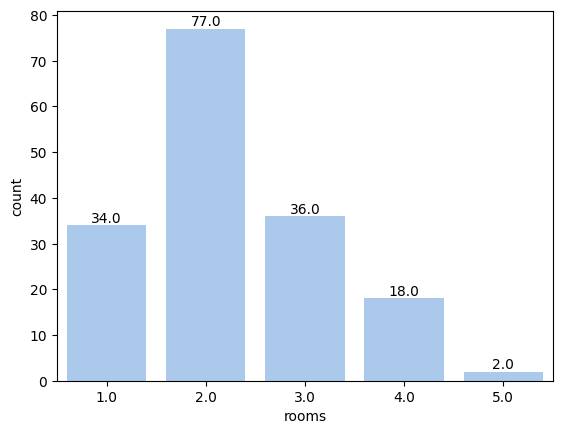

In [260]:
ax = sns.countplot(df, x="rooms")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: TAGS -> creación de nuevas variables a partir de Tags
- PIECES: estancias del inmueble -> habitaciones + salon + cocina, no se cuentan los baños
- CHAMBRES: habitaciones, estancias para dormir.
- ETAGES: piso o altura.
- BALCON: balcon, no cabe una mesa con 4 sillas.
- TERRASSE: terrazas más grandes que los balcones, cabe mínimo una mesa con 4 sillas.
- ASCENSEUR: ascensor.
- PARKING: plaza de parking exterior privada, normalmente no cubierta.
- BOX: plaza de parking interior privada, normalmente cubierta. Es lo mismo que un Garaje.
- JARDIN: jardin.
- PISCINE: piscina.

In [261]:
df.tags
df_a_predecir.tags

,tags
0,"2 pieces, 1 chambre, 42m2, etage 1/2, terras..."


#### Variable PIECES (Estancias)

<font color="red">Finalmente no vamos a utilizar esta variable ya que tenemos la misma información en la variable "rooms".</font>

In [262]:
# df["pieces"] = df.tags.str.split(',').str.get(0)
# df_a_predecir["pieces"] = df_a_predecir.tags.str.split(',').str.get(0)

In [263]:
# sorted_order = df['pieces'].sort_values()

# ax = sns.countplot(df, x="pieces", order=sorted_order)

# for p in ax.patches:
#     height = p.get_height()
#     ax.annotate(f'{height}',
#                 (p.get_x() + p.get_width() / 2, height),
#                 ha = 'center', va = 'center',
#                 xytext = (0, 5),
#                 textcoords = 'offset points')

# plt.show()

Se tendría que realizar una comparativa entre "Rooms" y "Pieces", ya que muestran valores distintos pero deberían ser iguales (no lo voy a hacer en este momento).

#### Variable CHAMBRES (Habitaciones)

In [264]:
def extract_chambres(tag):
    # Vérifie si l'entrée est une chaîne de caractères
    if isinstance(tag, str):
        # Vérifie si 'chambre' ou 'chambres' est dans la chaîne de caractères
        if 'chambre' in tag or 'chambres' in tag:
            # Sépare la chaîne par des virgules
            parts = tag.split(',')
            # Parcourt les parties séparées pour trouver la mention de chambres
            for part in parts:
                part = part.strip()  # Supprime les espaces blancs autour
                if 'chambre' in part or 'chambres' in part:
                    return part
    return '0 chambres'

# Applique la fonction à la colonne 'tags'
df['chambres'] = df['tags'].apply(extract_chambres)
df_a_predecir['chambres'] = df_a_predecir['tags'].apply(extract_chambres)

In [265]:
df['chambres'] = df.chambres.str.split().str.get(0)
df_a_predecir['chambres'] = df_a_predecir.chambres.str.split().str.get(0)

df['chambres'] = pd.to_numeric(df['chambres'])
df_a_predecir['chambres'] = pd.to_numeric(df_a_predecir['chambres'])

df.chambres.dtypes
df_a_predecir.chambres.dtypes

dtype('int64')

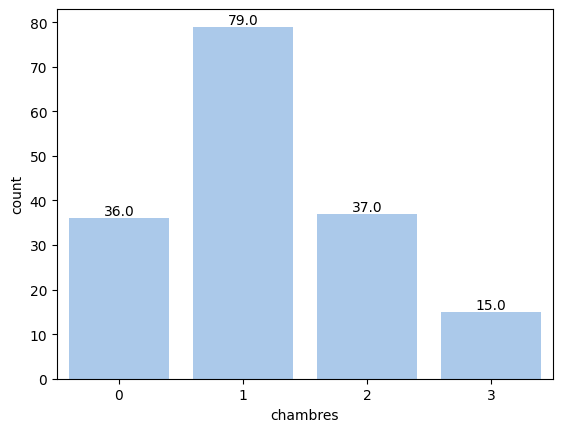

In [266]:
sorted_order = df['chambres'].sort_values()

ax = sns.countplot(df, x="chambres", order=sorted_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

Esta variable es la misma que "bedrooms" en el dataset, pero la hemos quitado al principio ya que no está completa, por lo tanto nos vamos a fiar de este dato.

#### Variable ETAGES (piso o altura)

In [267]:
def extract_etages(tag):
    if isinstance(tag, str):
      # Vérifie si 'chambre' ou 'chambres' est dans la chaîne de caractères
      if 'etage' in tag or 'etages' in tag:
          # Sépare la chaîne par des virgules
          parts = tag.split(',')
          # Parcourt les parties séparées pour trouver la mention de chambres
          for part in parts:
              part = part.strip()  # Supprime les espaces blancs autour
              if 'etage' in part or 'etages' in part:
                  return part
    return '0'

# Applique la fonction à la colonne 'tags'
df['etages'] = df['tags'].apply(extract_etages)
df_a_predecir['etages'] = df_a_predecir['tags'].apply(extract_etages)

In [268]:
df['etages'] = df['etages'].str.replace('â', '-', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/0', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/0 ', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/2', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/3', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 33/0', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/4', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/5', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/0', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/0', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/0', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/0', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/0', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/-', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/–', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/-', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/–', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/-', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/–', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 6/-', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 6/–', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 7/–', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/-', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/–', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/-', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/–', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/-', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/–', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/–', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/2', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/2', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 32/3', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/2', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/3', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/4', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/5', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/3', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/4', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/5', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/3', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/4', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/5', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/4', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/5', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/6', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/5', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/6', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/6', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/6', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/6', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/6', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 6/6', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -/0', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage –/0', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage –/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage –/2', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -/3', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage –/3', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -/4', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage –/4', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -/5', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/6', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 0/7', '0', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/7', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/7', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/7', '3', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 4/7', '4', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/7', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 6/7', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 7/7', '7', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 1/8', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 2/8', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 5/8', '5', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 6/8', '6', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 7/8', '7', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 7/9', '7', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/2', '2', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 3/1', '1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -1/1', '-1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage -1/–', '-1', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('etage 7/0', '7', regex=False).str.strip()
df['etages'] = df['etages'].str.replace('unknown', '0', regex=False).str.strip()
df_a_predecir['etages'] = df_a_predecir['etages'].str.replace('etage 1/2', '1', regex=False).str.strip()

In [269]:
df['etages'] = df.etages.str.split().str.get(0)
df_a_predecir['etages'] = df_a_predecir.etages.str.split().str.get(0)

df['etages'] = pd.to_numeric(df['etages'])
df_a_predecir['etages'] = pd.to_numeric(df_a_predecir['etages'])

print(df['etages'].dtype)
print(df_a_predecir['etages'].dtypes)

int64
int64


In [270]:
df.etages.value_counts()

,count
etages,
2,42
1,38
0,34
3,25
4,20
5,6
6,1
7,1


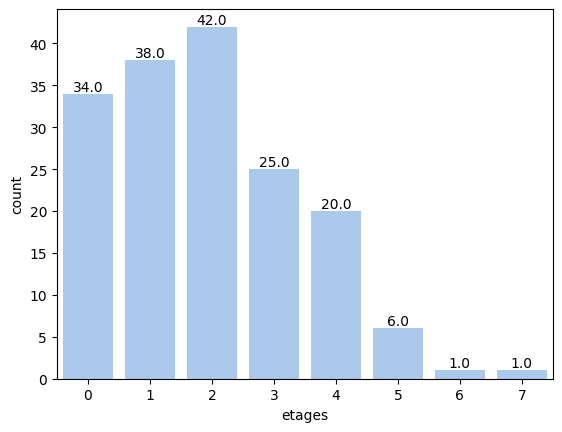

In [271]:
sorted_order = df['etages'].sort_values()

ax = sns.countplot(df, x="etages", order=sorted_order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable BALCON

In [272]:
def extract_balcon(tag):
  if isinstance(tag, str):
    if 'balcon' in tag or 'balcons' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['balcon'] = df['tags'].apply(extract_balcon)
df_a_predecir['balcon'] = df_a_predecir['tags'].apply(extract_balcon)

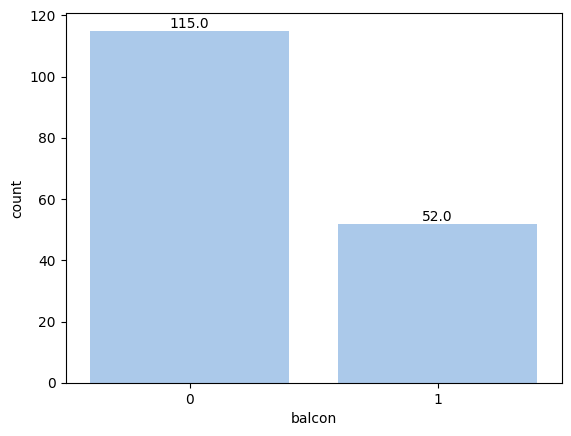

In [273]:
ax = sns.countplot(df, x="balcon")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable TERRASSE (terraza)

In [274]:
def extract_terrasse(tag):
  if isinstance(tag, str):
    if 'terrasse' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['terrasse'] = df['tags'].apply(extract_terrasse)
df_a_predecir['terrasse'] = df_a_predecir['tags'].apply(extract_terrasse)

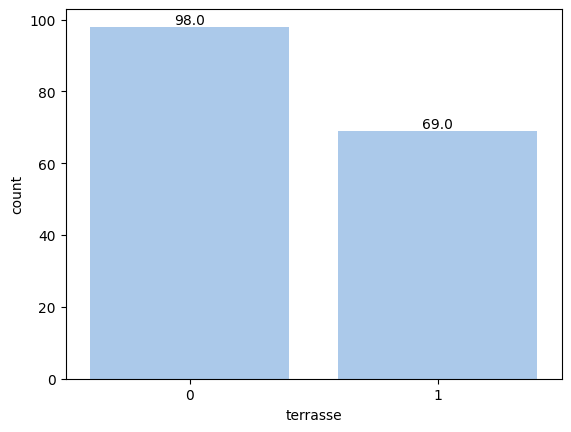

In [275]:
ax = sns.countplot(df, x="terrasse")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable PARKING EXTERIOR

In [276]:
def extract_parking(tag):
  if isinstance(tag, str):
    if 'parking' in tag or 'parkings' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['parking'] = df['tags'].apply(extract_parking)
df_a_predecir['parking'] = df_a_predecir['tags'].apply(extract_parking)

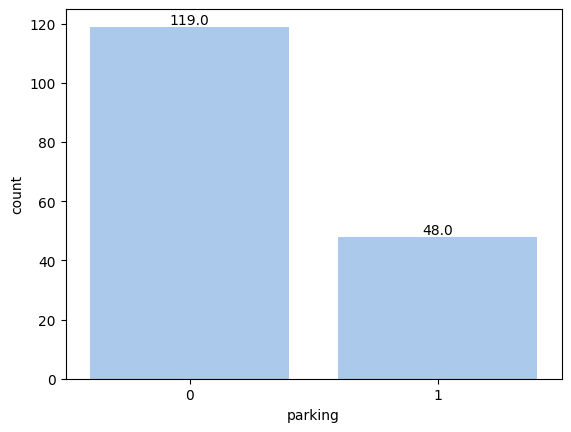

In [277]:
ax = sns.countplot(df, x="parking")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable ASCENSEUR (ascensor)

In [278]:
def extract_ascenseur(tag):
  if isinstance(tag, str):
    if 'ascenseur' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['ascenseur'] = df['tags'].apply(extract_ascenseur)
df_a_predecir['ascenseur'] = df_a_predecir['tags'].apply(extract_ascenseur)

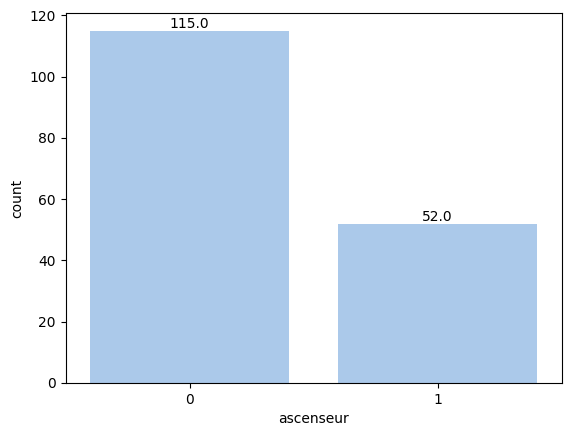

In [279]:
ax = sns.countplot(df, x="ascenseur")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable BOX (garaje)

In [280]:
def extract_box(tag):
  if isinstance(tag, str):
    if 'box' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['box'] = df['tags'].apply(extract_box)
df_a_predecir['box'] = df_a_predecir['tags'].apply(extract_box)

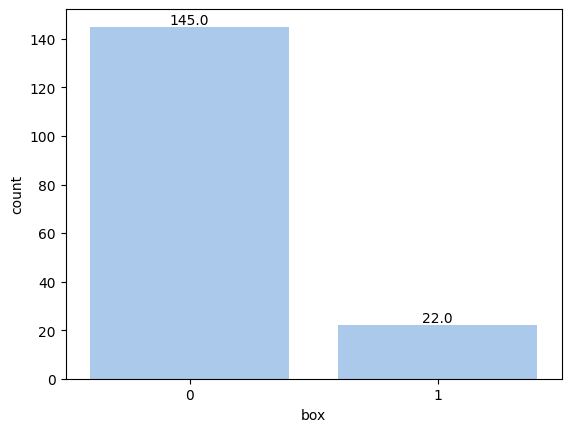

In [281]:
ax = sns.countplot(df, x="box")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable JARDIN

In [282]:
def extract_jardin(tag):
  if isinstance(tag, str):
    if 'jardin' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['jardin'] = df['tags'].apply(extract_jardin)
df_a_predecir['jardin'] = df_a_predecir['tags'].apply(extract_jardin)

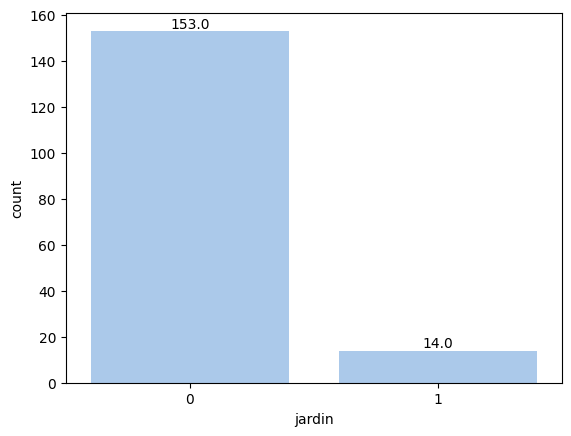

In [283]:
ax = sns.countplot(df, x="jardin")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

#### Variable PISCINE (piscina)

In [284]:
def extract_piscine(tag):
  if isinstance(tag, str):
    if 'piscine' in tag:
      return 1
  return 0

# Applique la fonction à la colonne 'tags'
df['piscine'] = df['tags'].apply(extract_piscine)
df_a_predecir['piscine'] = df_a_predecir['tags'].apply(extract_piscine)

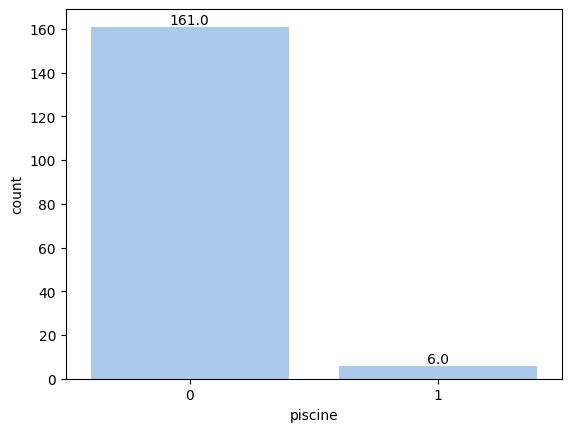

In [285]:
ax = sns.countplot(df, x="piscine")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: SOLD

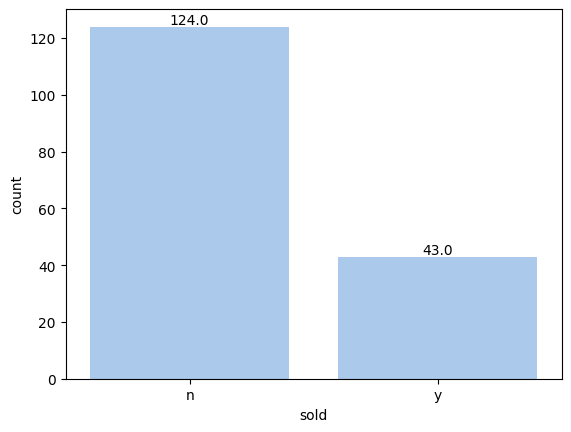

In [286]:
ax = sns.countplot(df, x="sold")

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

### Variable: SELLING TIME (entendido como el tiempo en que el anuncio está activo)

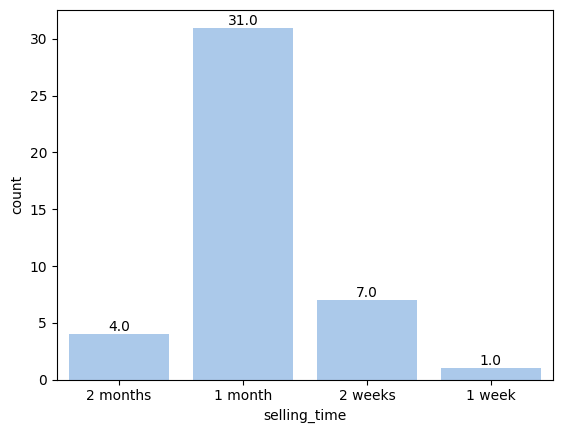

In [287]:
df_no_null = df.dropna(subset=['selling_time'])
order = ['2 months', '1 month', '2 weeks', '1 week', ]

ax = sns.countplot(df, x="selling_time", order=order)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}',
                (p.get_x() + p.get_width() / 2, height),
                ha = 'center', va = 'center',
                xytext = (0, 5),
                textcoords = 'offset points')

plt.show()

Vamos a mirar cuáles son los tiempos de venta por cada distrito y tipo de apartamento:

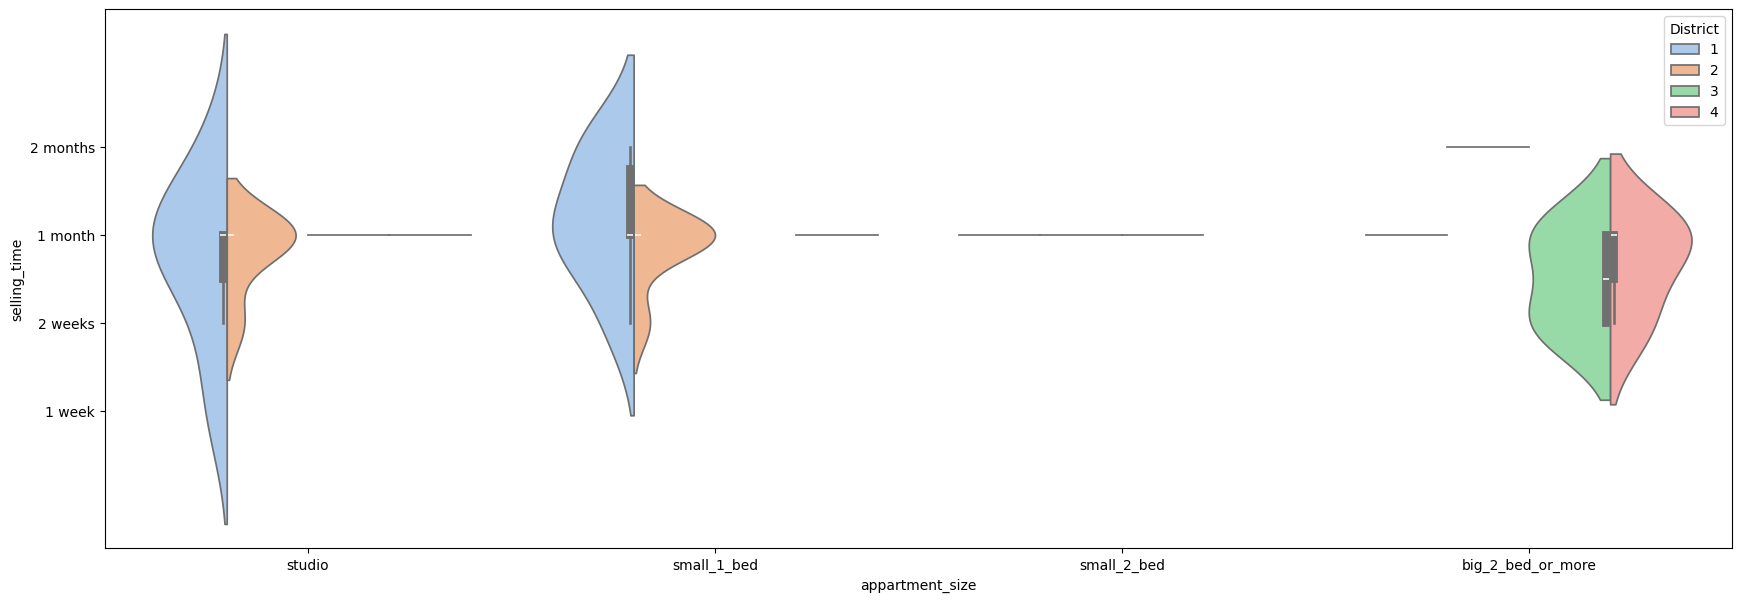

In [293]:
order = ['2 months', '1 month', '2 weeks', '1 week', ]
df['selling_time'] = pd.Categorical(df['selling_time'], categories=order, ordered=True)
df_no_null = df.dropna(subset=['selling_time'])

fig, ax = plt.subplots(figsize=(21, 7))

# Create a violin plot
sns.violinplot(x='appartment_size', y='selling_time', hue='district', data=df_no_null, ax=ax, split=True, palette="pastel")

# Optionally, add a legend
ax.legend(title='District')

plt.show()

### Variable: OLD PRICE

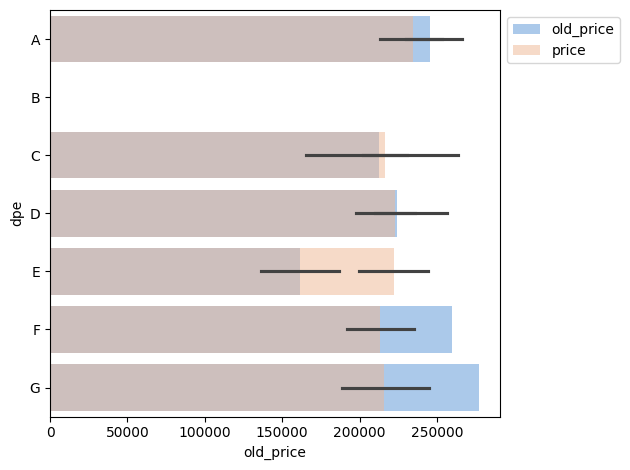

In [289]:
category_order = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
df_not_zero = df[df['old_price'] != 0]

palette = sns.color_palette("pastel")

sns.barplot(x="old_price", y=df['dpe'], data=df_not_zero,
            label="old_price", order=category_order, color=palette[0])

sns.barplot(x="price", y=df['dpe'], data=df_not_zero,
            label="price", color=palette[1], order=category_order, alpha=0.5)

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

plt.show()

Vemos que los precios que más bajan son los de los apartamentos con eficiencia energética F. Resulta curioso que el precio final de los calificados como G, la peor eficiencia energética, sea mayor que el old_price. Esto podría deberse a que hay muy pocos pisos clasificados como G ya que se habrían clasificado como F para que resultaran más fáciles de vender.

### Tabla y gráfico de correlaciones entre las variables numéricas

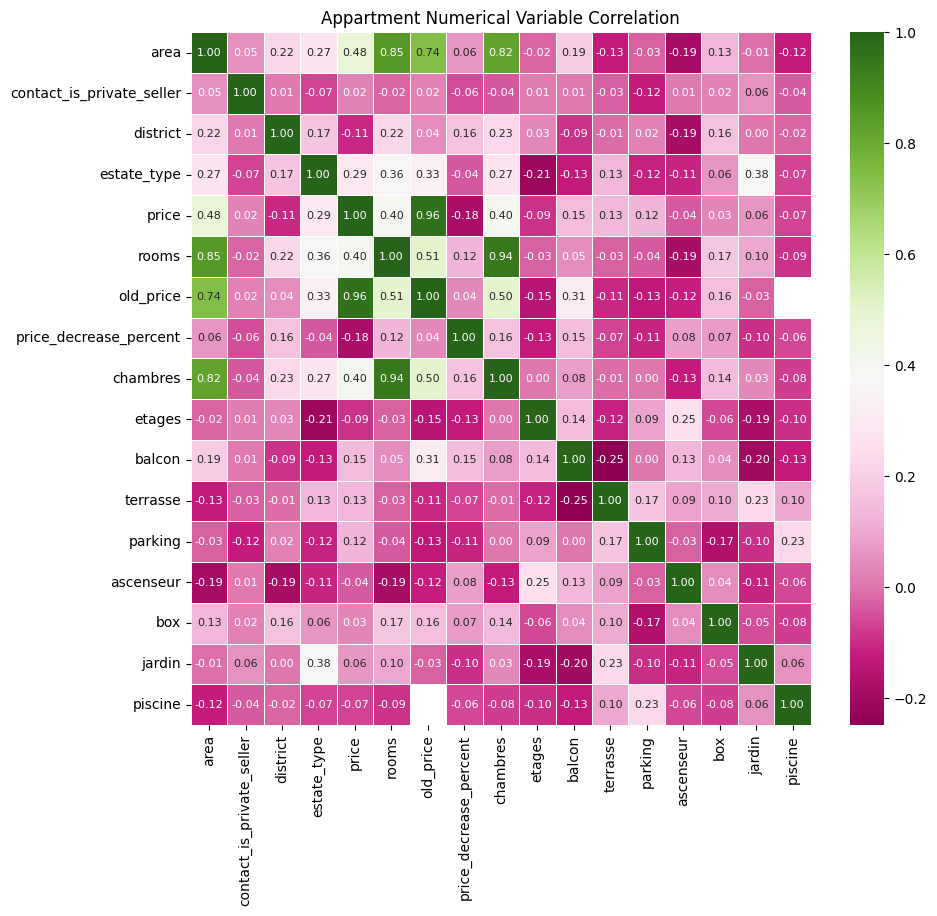

In [295]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr(numeric_only=True)
plt.subplots(figsize=(10,9))
sns.heatmap(correlation_matrix, annot=True, linewidths=.5, cmap='PiYG', fmt=".2f", annot_kws={"size":8})
plt.title("Appartment Numerical Variable Correlation")
plt.show()

Nos damos cuenta rápidamente en la variabilidad tan grande que hay en los precios. Por ejemplo, vemos que la superficie sólo correlaciona un 0.47 con el precio, y el número de habitaciones y de estancias sólo un 0.39 y 0.41 respectivamente. El resto de factores no parecen influir prácticamente nada en el precio. Esto nos indica que las relaciones entre variables de este dataset no son lineales y que vamos a tener dificultades para hacer funcionar nuestros modelos de regresión de ML.

### Exportamos las tablas limpias (la train-test y la predict) para utilizarlas con nuestros algoritmos de Machine Learning Automático

In [291]:
df.to_csv('df_real_estate_cleaned.csv', index=False, decimal=',')
df_a_predecir.to_csv('df_real_estate_cleaned_predict.csv', index=False, decimal=',')